In [ ]:
comp='shannon'
meas = 'silta9a'

%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np 
import matplotlib.pyplot as plt
import os 

import scresonators.measurement.handy as hy
import scresonators.measurement.helpers as helpers
from scresonators.fitting import ana_tls, resonator_helpers

helpers.config_figs()

if comp=='shannon':
    pth_base ='/Users/sph/Library/CloudStorage/GoogleDrive-circuitqed@gmail.com/'
elif comp=='bf1':
    pth_base='G:/'

cloud_folder = os.path.join(pth_base, 'My Drive/Projects/Materials')
data_folder = os.path.join(cloud_folder, 'Data')
img_pth = os.path.join(cloud_folder, 'Outputs/Resonators')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
cfg, data_pth, folder, img_name, ind = hy.get_params('../configs/mini2.yml', meas, pth=data_folder)

['fit_results_freq_4089MHz.csv', 'fit_results_freq_5056MHz.csv', 'fit_results_freq_5454MHz.csv', 'fit_results_freq_6319MHz.csv', 'fit_results_freq_7724MHz.csv']


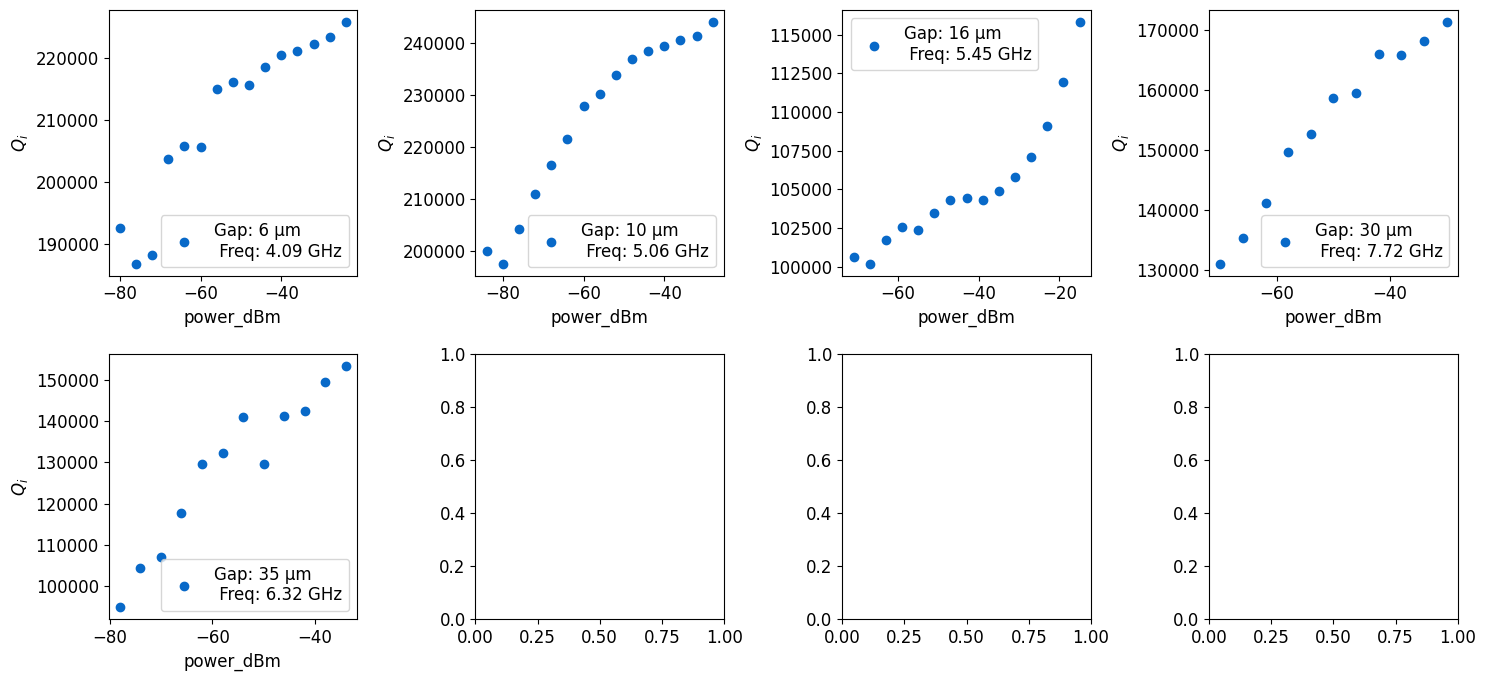

In [ ]:
df_full = resonator_helpers.load_resonator_csv(data_pth, cfg, xval='power_dBm')#, xval='power_dBm')

Fitting failed: Optimal parameters not found: The maximum number of function evaluations is exceeded.
Fitting failed: Optimal parameters not found: The maximum number of function evaluations is exceeded.


Traceback (most recent call last):
  File "/Users/sph/Documents/Git/scresonators/fitting/ana_tls.py", line 237, in _fit_qi_model
    p, err = curve_fit(
             ^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py", line 1029, in curve_fit
    raise RuntimeError("Optimal parameters not found: " + res.message)
RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.
Traceback (most recent call last):
  File "/Users/sph/Documents/Git/scresonators/fitting/ana_tls.py", line 237, in _fit_qi_model
    p, err = curve_fit(
             ^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py", line 1029, in curve_fit
    raise RuntimeError("Optimal parameters not found: " + res.message)
RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.


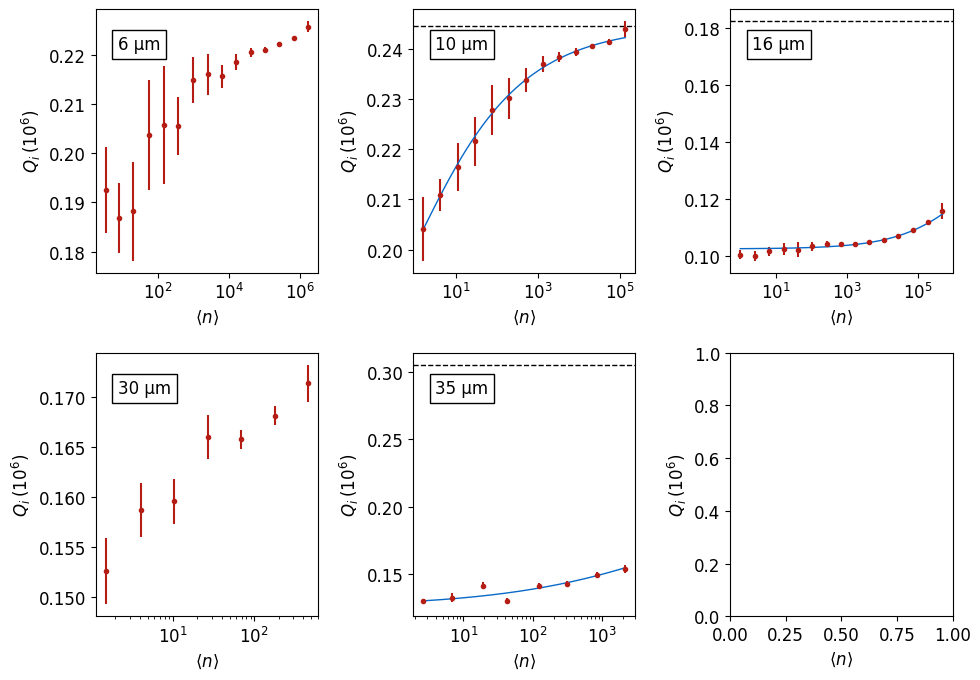

In [ ]:
# Ways to filter data points: 
    # Set min and max photons to include 
    # Exclude certain values (first create list of lists with size number of resonators, then add values to each to exclude) 
    # Set max value for qother for given resonator 

# option show_all: show all data points (True) or only those used in fit (False)
# option wide: plot wider range of photon numbers than we actually have for data. 
# Plots the Qother fit to a dashed black line

max_photon = [1e8, 1.2e9, 8e8, 1.5e9, 2e9, 1e7]
min_photon = [1, 1, 1, 1, 1, 1]
exclude = [None] * len(max_photon)  
#exclude[4]=[11] # This would exclude the 11th point for 4th resonator (counting from max power)
q_other_bounds = [np.inf, np.inf, np.inf, np.inf, np.inf]  # Example bounds for Qoth

#cfg = ana_tls.fit_qi2(df_full, img_pth, name=img_name)
cfg = ana_tls.fit_qi2(df_full, img_pth, name=img_name, max_photon_vec=max_photon, min_photon_vec=min_photon, exclude=exclude, q_other_bounds=q_other_bounds, show_all=False, wide=False) 
#cfg = ana_tls.fit_qi2(df_full, img_pth, name=img_name, max_photon_vec=max_photon, min_photon_vec=min_photon, show_all=True, wide=False, q_other_bounds=q_other_bounds) 

/Users/sph/Documents/Git/scresonators/fit_resonator/../../scresonators/fit_resonator/ana_tls.py:584: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0].set_ylabel("$Q_c \; (10^6)$")


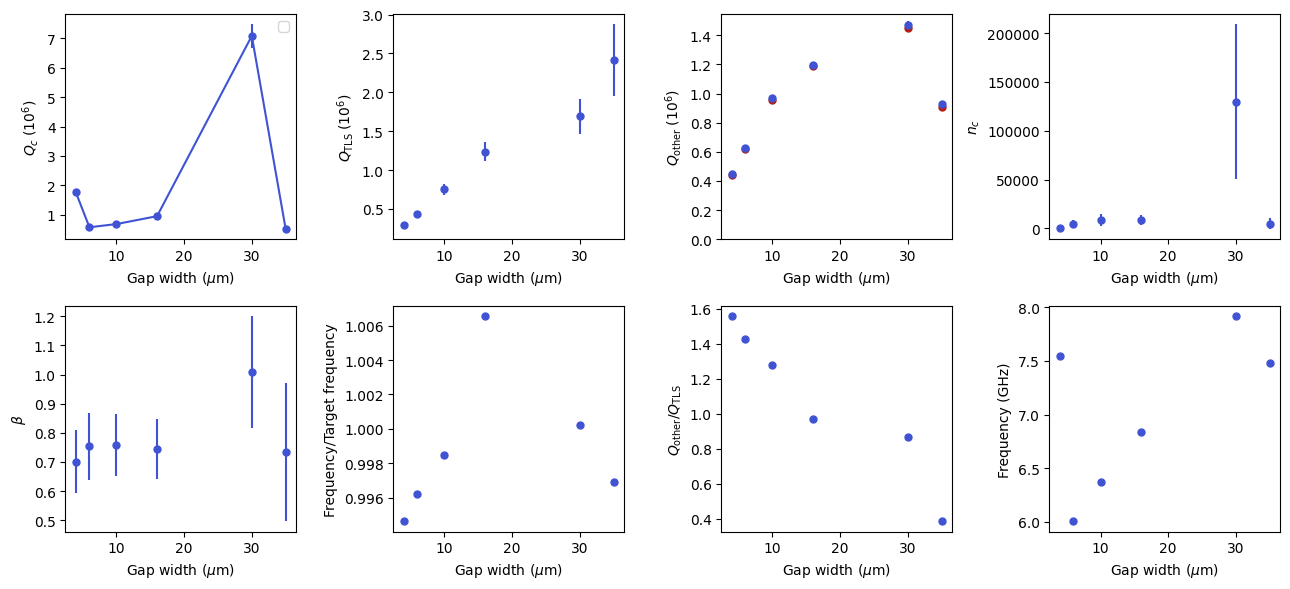

In [ ]:
ana_tls.plot_res_pars([cfg], [''],img_pth, name=img_name)
hy.save_np(cfg, img_pth+'Text/' +cfg['pth'][ind][0:-1] +cfg['meas'][ind] + '.yml')

# Use this to compare multiple

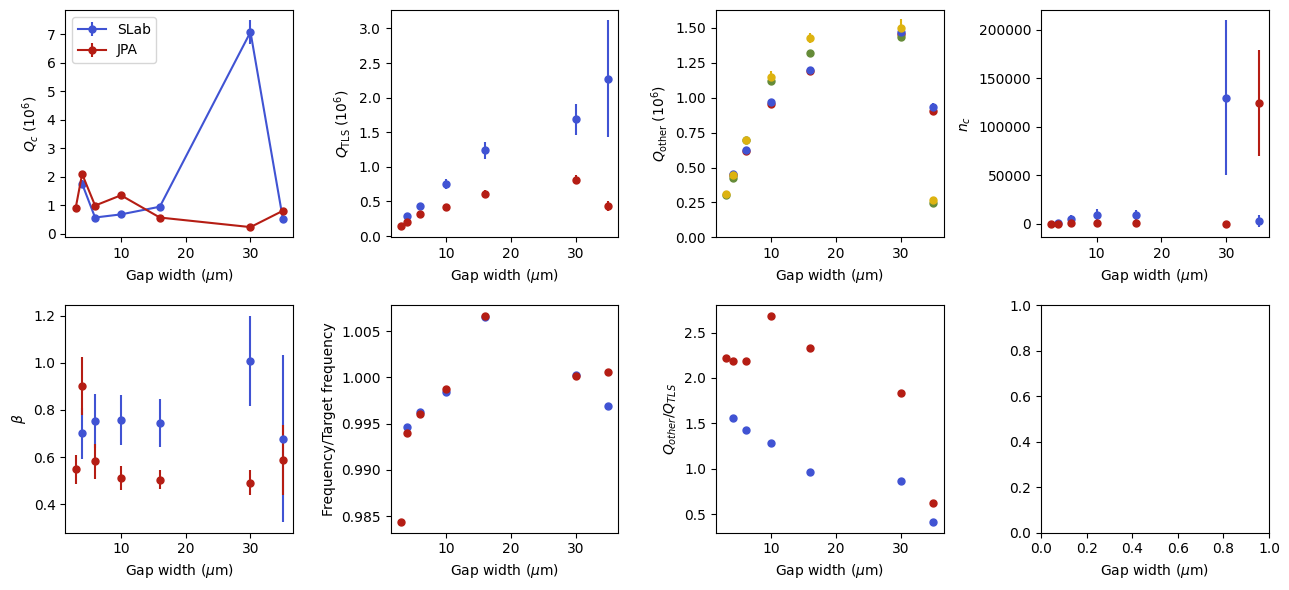

In [284]:
pnames = ['20250728-ResSilTa-Aggron-Slabsilta8_slab' ,'20250728-ResSilTa-Aggron-JPAsilta8_jpa']
labs = ['SLab', 'JPA'] 
plist =[]
for p in pnames:
    plist.append(hy.load(img_pth +'Text/'+ p + '.yml'))

ax=ana_tls.plot_res_pars(plist, labs,img_pth, name=pnames[0]+'_' +pnames[1])
#ResonatorPlotter.plot_res_pars(plist, labs,img_pth)